In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. 데이터 로드

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


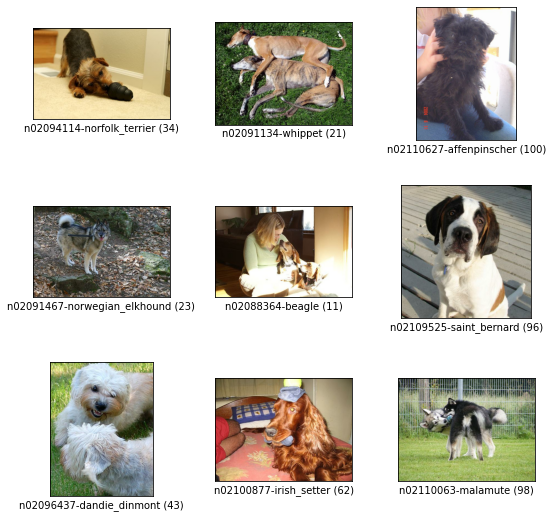

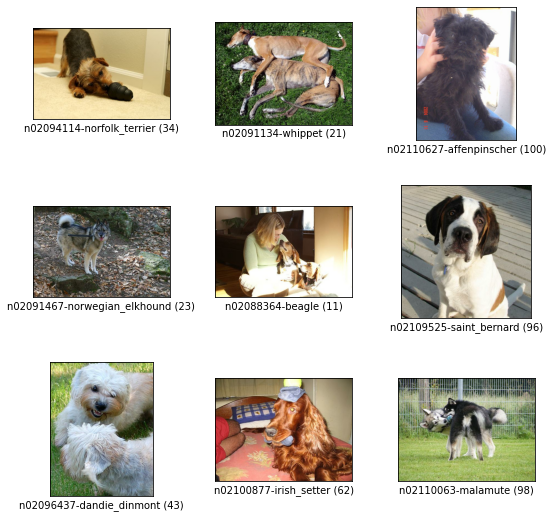

In [4]:
tfds.show_examples(ds_train, ds_info)

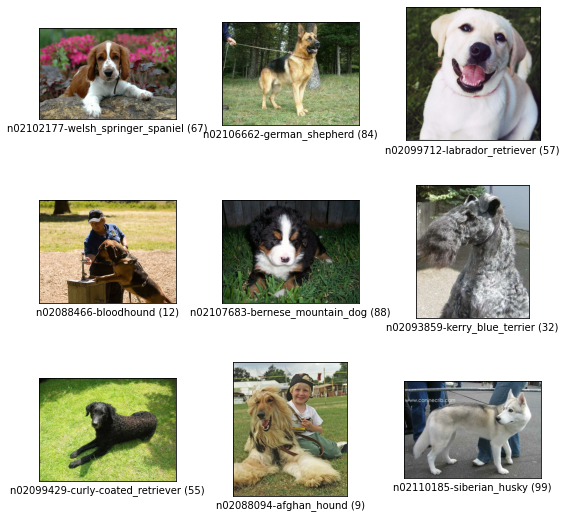

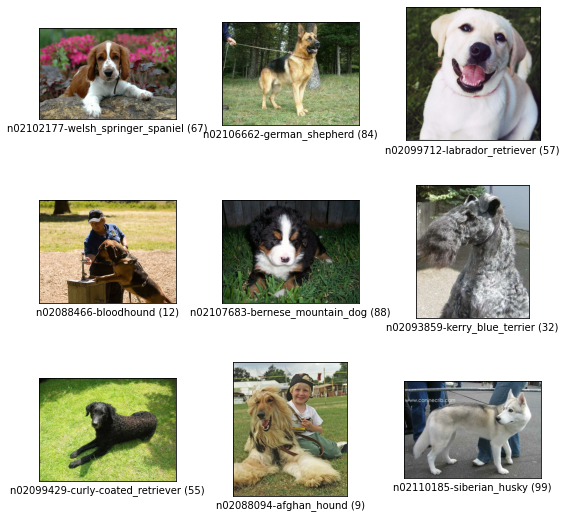

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

# 2. 모델 구조 설계

In [19]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [20]:
cam_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [21]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_crop(image,size=[224,224,3])
    #image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.map(
            augment
        )
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [22]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train, is_test=True)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


# 3 모델 학습 

In [23]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [24]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 213ms/step - loss: 2.2548 - accuracy: 0.4333 - val_loss: 3.4343 - val_accuracy: 0.1972
Epoch 2/20
750/750 [==============================] - 159s 212ms/step - loss: 0.6355 - accuracy: 0.8324 - val_loss: 1.3023 - val_accuracy: 0.6152
Epoch 3/20
750/750 [==============================] - 159s 212ms/step - loss: 0.1673 - accuracy: 0.9772 - val_loss: 1.0592 - val_accuracy: 0.6970
Epoch 4/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0580 - accuracy: 0.9969 - val_loss: 0.9762 - val_accuracy: 0.7254
Epoch 5/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0295 - accuracy: 0.9989 - val_loss: 0.9823 - val_accuracy: 0.7255
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0192 - accuracy: 0.9993 - val_loss: 0.9631 - val_accuracy: 0.7332
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0134 - accuracy: 0.9996 - val_loss: 0.9847 -

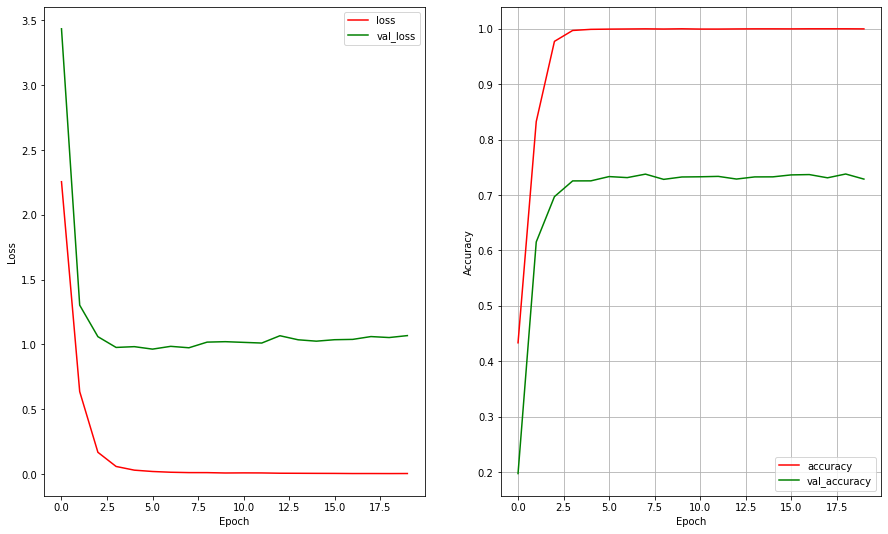

In [471]:

fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(history_cam_model.history['loss'], 'r', label='loss')
ax1.plot(history_cam_model.history['val_loss'], 'g', label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(history_cam_model.history['accuracy'], 'r', label='accuracy')
ax2.plot(history_cam_model.history['val_accuracy'], 'g', label='val_accuracy')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid()

fig.show()

모델이 어느정도 안정적인 정확도까지 수렴되는 것을 확인

# 4. 모델 저장 후 로드

In [26]:
cam_model.save('./model/model.h5')

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [446]:
cam_model =  keras.models.load_model('./model/model.h5')

In [447]:
def get_one(ds):#데이터 이미지 추출
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())#데이터셋 모든요소를 numpy로 반환
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


80


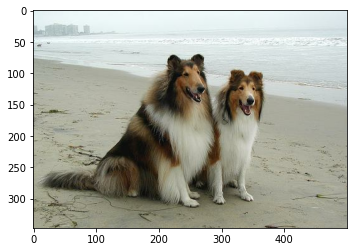

In [448]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

# 5. CAM 이미지 추출

In [449]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))# 축 하나 추가 인풋 size를 맞추기위해
    conv_outputs = conv_outputs[0, :, :, :]## 7 7 2048
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] # 2048, 128
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])# 7,7
    #7,7,2048  2048, 1 내적 계산

    """
    for i, w in enumerate(class_weights[:, class_idx]):# 2048, 1 특정 class 에 해당하는 가중치값만 가져와서 
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i] # 채널별*가중치 합연산
    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    print(np.max(test))
    print(cam_image.shape)
    print(np.max(cam_image))
    """
    
    cam_image=np.dot(conv_outputs,class_weights[:,class_idx]) # 채널별*가중치 합연산과 동일
    cam_image /= np.max(cam_image) # activation score를 normalize합니다. 최댓값을 1로 만든다
    cam_image[cam_image < 0]=0
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    #resize를 해도 되는 이유 
    #conv 레이어를 통해 이미지를 채널별로 나누어 각 특징을 함축적으로 포함되어있기때문이라고 생각한다
    #그렇다면 fully connected layer 경우에는 왜 사용하지 않을까?
    
    #fully connected layer를 통과하게되면 각 채널별을 하나로 합침으로써 
    #이미지의 위치정보를 깨뜨리기 때문에 사용하지 못하는 걸로 생각한다
    
    return cam_image

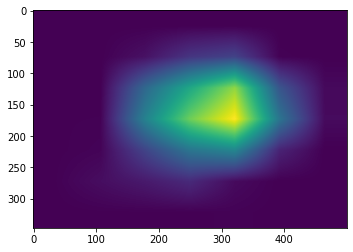

In [450]:
#마지막 층 레이어 시각화
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

# 6. 원본과 CAM 이미지 보간

In [451]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

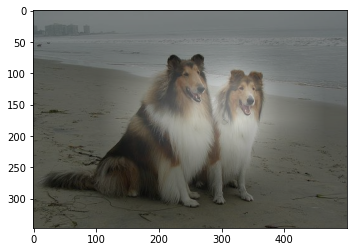

In [452]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

cam_blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(cam_blended_image)
plt.show()

# 7. Grad CAM 이미지 추출

In [453]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.
    #print(conv_output.shape)
    
    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    #print(weights.shape)
    #print(conv_output.shape[0:2])
    grad_cam_image = np.zeros(dtype=np.float32, shape=output.shape[0:2])
 
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
    print(grad_cam_image.shape)
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


In [454]:
#for w in cam_model.trainable_weights:
#    print(w.name)
#    print(w.shape)

(7, 7)


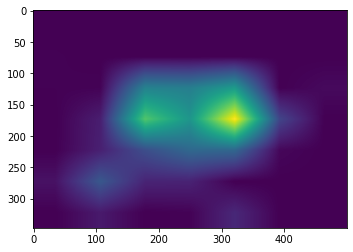

In [455]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)#conv5_block2_1_conv
plt.imshow(grad_cam_image)
plt.show()

# 8. 원본과 Grad CAM 이미지 보간

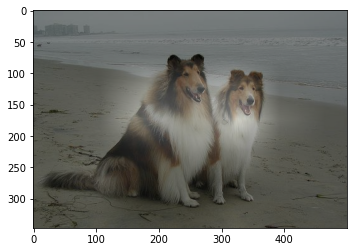

In [456]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

grad_cam_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(grad_cam_blended_image)
plt.show()

# 9. 마지막 층 레이어 말고 다른 층 레이어 시작화 

(14, 14)


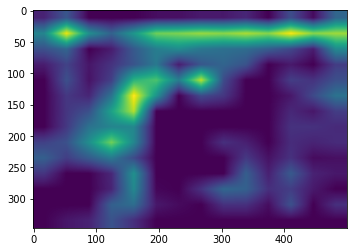

In [466]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block6_out', item)#conv5_block2_1_conv
plt.imshow(grad_cam_image)
plt.show()

(28, 28)


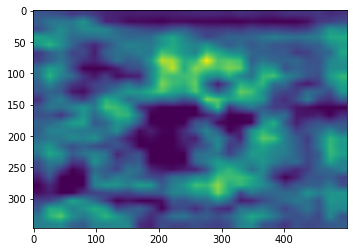

In [467]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block4_out', item)#conv5_block2_1_conv
plt.imshow(grad_cam_image)
plt.show()

# 10. 최종 결과
### (각 시각화 시킨 이미지의 bbox, IoU계산)
##### 결과는 아래만 보시면 됩니다

In [457]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [458]:
# cam 방식 bbox
cam_bbox = copy.deepcopy(item['image'])
cam_rect = get_bbox(copy.deepcopy(cam_image))
cv2.drawContours(cam_bbox, [cam_rect], 0, (0,0,255), 2)
print("")

In [459]:
# grad_cam 방식 bbox
grad_cam_bbox = copy.deepcopy(item['image'])
grad_cam_rect = get_bbox(copy.deepcopy(grad_cam_image))
cv2.drawContours(grad_cam_bbox, [grad_cam_rect], 0, (0,0,255), 2)
print("")

In [460]:
#원본 bbox
src_bbox = copy.deepcopy(item['image'])
width = item['image'].shape[1]
height = item['image'].shape[0]
y1,x1,y2,x2 = item['objects']['bbox'][0][:]
x1, x2, y1, y2 = x1*width, x2*width, y1*height, y2*height
cv2.rectangle(src_bbox, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0))
src_rect=[y1, x1, y2, x2 ]

In [461]:
#Iou 구하기
def rect_to_minmax(rect):
    bbox = [
        rect[:,1].min(),  #bounding box의 y_min
        rect[:,0].min(),  #bounding box의 x_min
        rect[:,1].max(), #bounding box의 y_max
        rect[:,0].max() #bounding box의 x_max
    ]
    return bbox
cam_rect = rect_to_minmax(cam_rect)
grad_cam_rect = rect_to_minmax(grad_cam_rect)

In [462]:
def get_iou(a, b):
    print(a,b)
    inter_start_Y = max(a[0],b[0])
    inter_start_X = max(a[1],b[1])
    inter_end_Y = min(a[2],b[2])
    inter_end_X = min(a[3],b[3])
    
    inter_X = max(0, inter_end_X - inter_start_X)
    inter_Y = max(0, inter_end_Y - inter_start_Y)
    
    inter_Area = inter_X * inter_Y
    
    A_Area = (a[3] - a[1]) * (a[2] - a[0])
    B_Area = (b[3] - b[1]) * (b[2] - b[0])
    
    iou = inter_Area / (A_Area + B_Area - inter_Area)
    return iou
    

In [463]:
#test 용도
get_iou(src_rect, cam_rect)

[68.0000021904707, 9.999999776482582, 313.99999475479126, 289.000004529953] [-16, 72, 334, 489]


0.331149735333815

[68.0000021904707, 9.999999776482582, 313.99999475479126, 289.000004529953] [-16, 72, 334, 489]


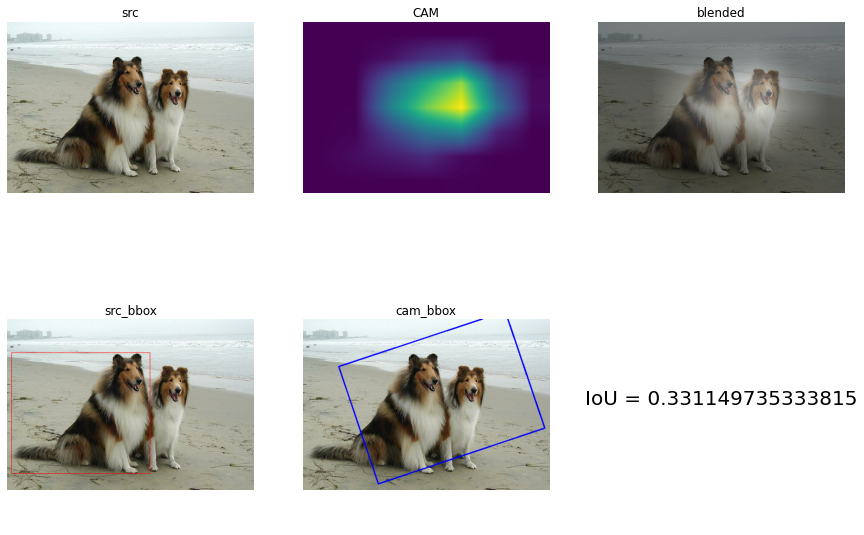

In [464]:
fig = plt.figure(figsize=(15,10))
img=[item['image'], cam_image, cam_blended_image, src_bbox, cam_bbox]
title=['src','CAM','blended','src_bbox','cam_bbox']
for i in range(6):
    
    ax = fig.add_subplot(2,3,i+1)
    ax.axis('off')
    if i==5:
        ax.text(0.5,0.5,"IoU = {0}".format(get_iou(src_rect, cam_rect)),fontsize=20, horizontalalignment='center')
        break
    ax.imshow(img[i])
    ax.set_title(title[i])
    
    
plt.show()

[68.0000021904707, 9.999999776482582, 313.99999475479126, 289.000004529953] [79, 37, 346, 446]


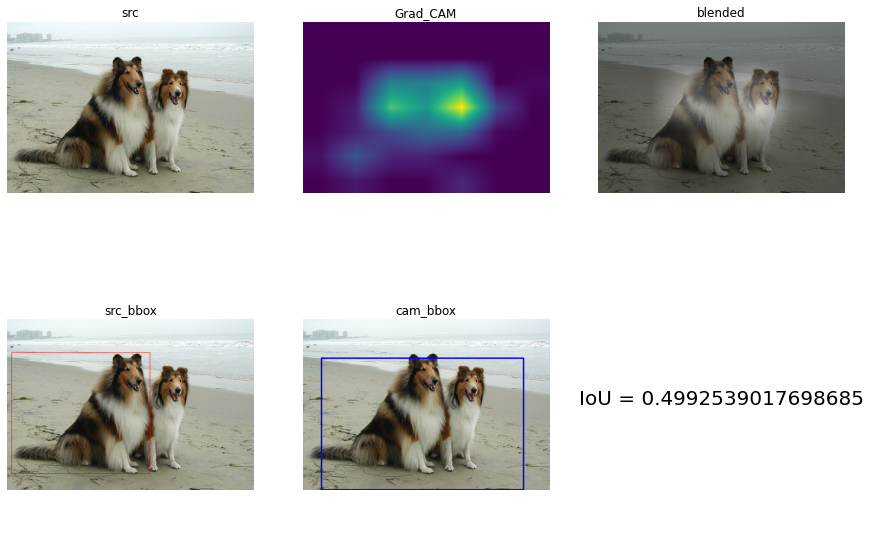

In [465]:
fig = plt.figure(figsize=(15,10))
img=[item['image'],grad_cam_image, grad_cam_blended_image, src_bbox, grad_cam_bbox]
title=['src','Grad_CAM','blended','src_bbox','cam_bbox']
for i in range(6):
    
    ax = fig.add_subplot(2,3,i+1)
    ax.axis('off')
    if i==5:
        ax.text(0.5,0.5,"IoU = {0}".format(get_iou(src_rect, grad_cam_rect)),fontsize=20, horizontalalignment='center')
        break
    ax.imshow(img[i])
    ax.set_title(title[i])
    
    
plt.show()

# 11. 결론